## Perceptrón multicapa

En esta parte de la práctica vamos a crear una red neuronal profunda, definiendo:
- la capa de entrada, 
- las capas ocultas, 
- una capa de dropout para mejorar los resultados y evitar overfitting 
- y, finalmente, la capa de salida.

Con la librería keras_tuner, vamos a optimizar la estructura de la red neural, ya que, vamos a seleccionar el número óptimo de neuronas, el número de capas ocultas y la cantidad de dropout a aplicar. Y todo ello de manera automática.

Vamos a analizar distintos métodos para realizar la optimización de los hiperparámetros con Hyperband.

En primer lugar realizamos las importaciones necesarias y cargando los sets de datos.

In [70]:
#!pip install keras_tuner
#!pip install tensorflow

In [71]:
# Importamos las librerías necesarias.
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split


In [72]:
# Importamos los datos de test, train y val.
X_train = pd.read_csv("./DatosAbandonoSinPondSinNanSub/X_train.csv", sep=',', decimal='.')
y_train = pd.read_csv("./DatosAbandonoSinPondSinNanSub/y_train.csv", sep=',', decimal='.')
#X_val = pd.read_csv("./DatosAbandonoSinPondSinNanSub/X_val.csv", sep=',', decimal='.')
#y_val = pd.read_csv("./DatosAbandonoSinPondSinNanSub/y_val.csv", sep=',', decimal='.')
X_test = pd.read_csv("./DatosAbandonoSinPondSinNanSub/X_test.csv", sep=',', decimal='.')
y_test = pd.read_csv("./DatosAbandonoSinPondSinNanSub/y_test.csv", sep=',', decimal='.')



In [73]:
y_train.head()

,DROPOUT_RISK
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [74]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
#scaler = preprocessing.Normalizer().fit(X_train)
X_train = scaler.transform(X_train)
#X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train = y_train
#y_val = y_val
y_test = y_test


In [75]:
from tensorflow.keras.utils import to_categorical

In [76]:
# Pasamos a etiquetas one-hot encoded #(X)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [77]:
print(X_train)
print(y_train.shape)


[[-0.66351371 -0.08788857 -0.06848728 ...  0.59145904  0.17949632
  -0.34345195]
 [-0.63600507 -0.52430352 -0.08451685 ...  0.60602674  0.60528145
   0.32657895]
 [-0.49234883 -0.53762183 -0.01719265 ... -0.68425372 -0.12792844
  -0.85689288]
 ...
 [-0.22541314 -0.45002304  1.2395258  ... -2.41846921 -3.27628582
  -2.48370736]
 [ 1.03319205 -0.8549958   0.02127832 ... -1.42918381 -2.16202626
  -1.30006069]
 [ 1.16530145 -0.71824284 -1.68747406 ... -1.27988723 -0.41082734
  -0.82501477]]
(12153, 3)


In [78]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

Definimos la función que va a probar las distintas combinaciones de hyperparámetros que le indiquemos.
Esta función equivale a un GridSearch por fuerza bruta, donde probaremos varios valores de capas, número de neuronas, de dropout y learning rate.

Para facilitar el cómputo, sólo se ha implementado una capa 

In [79]:
def model_builder(hp):
    # Definición del modelo
    model = keras.Sequential()

    # Tuning del número de neuronas de las hidden layer
    hp_units = hp.Int('units', min_value=8, max_value=128, step=8)
    
    # Tuning del número de capas
    hp_layers = hp.Int('layers', min_value=1, max_value=5, step=1)
    
    # Input layer
    model.add(layers.Dense(units=128, activation='relu', input_shape=(X_test.shape[1],)))
    
    # Hidden layers 
    for i in range(hp_layers):
        # Añadimos la hidden layer
        model.add(layers.Dense(units=hp_units, activation='relu'))
        
    # Output layer
    model.add(layers.Dense(3, activation='softmax'))
    
    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5,1e-6])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
        #optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [80]:
tuner = kt.Hyperband(
    model_builder,
    objective= 'val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hp_dir',
    project_name='ruters_dataset',
    overwrite = True
)

In [81]:
# Creamos una función de callback que limpie el output
import IPython
import tensorflow as tf

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [82]:
# Ejecución del proceso de tuning
tuner.search(
    X_train, 
    y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 05s]
val_accuracy: 0.6824352145195007

Best val_accuracy So Far: 0.9292472004890442
Total elapsed time: 00h 01m 15s
INFO:tensorflow:Oracle triggered exit


In [83]:
# Obtención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps.get('units'))
print("Layers:", best_hps.get('layers'))

Units: 48
Layers: 3


In [84]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train,
    y_train,
    epochs = 20,
    validation_split = 0.2,
    shuffle = True
)

Epoch 1/20
304/304 [==============================] - 1s 1ms/step - loss: 1.0416 - accuracy: 0.5309 - val_loss: 1.0541 - val_accuracy: 0.5537
Epoch 2/20
304/304 [==============================] - 0s 1ms/step - loss: 1.0158 - accuracy: 0.5502 - val_loss: 1.0175 - val_accuracy: 0.6277
Epoch 3/20
304/304 [==============================] - 0s 1ms/step - loss: 1.0013 - accuracy: 0.5570 - val_loss: 0.9949 - val_accuracy: 0.6508
Epoch 4/20
304/304 [==============================] - 0s 1ms/step - loss: 0.9911 - accuracy: 0.5606 - val_loss: 0.9753 - val_accuracy: 0.6619
Epoch 5/20
304/304 [==============================] - 0s 1ms/step - loss: 0.9827 - accuracy: 0.5630 - val_loss: 0.9620 - val_accuracy: 0.6763
Epoch 6/20
304/304 [==============================] - 0s 1ms/step - loss: 0.9750 - accuracy: 0.5657 - val_loss: 0.9485 - val_accuracy: 0.6791
Epoch 7/20
304/304 [==============================] - 0s 1ms/step - loss: 0.9678 - accuracy: 0.5691 - val_loss: 0.9299 - val_accuracy: 0.6898
Epoch 

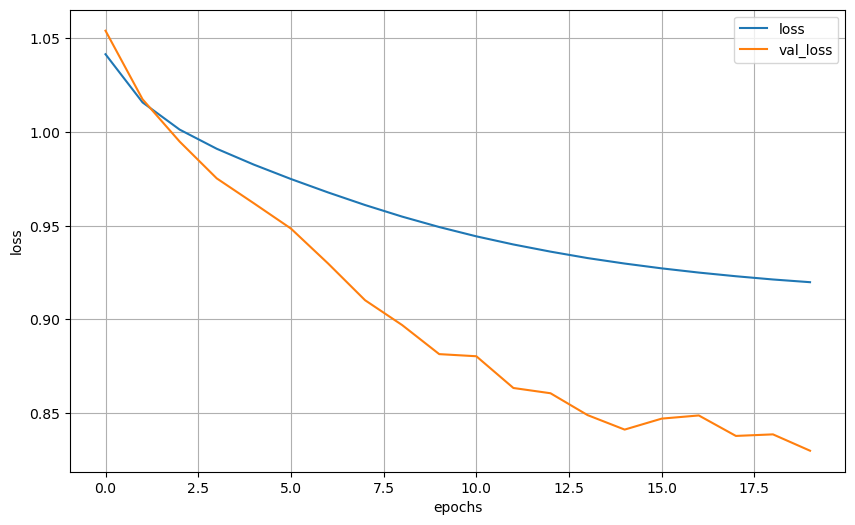

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

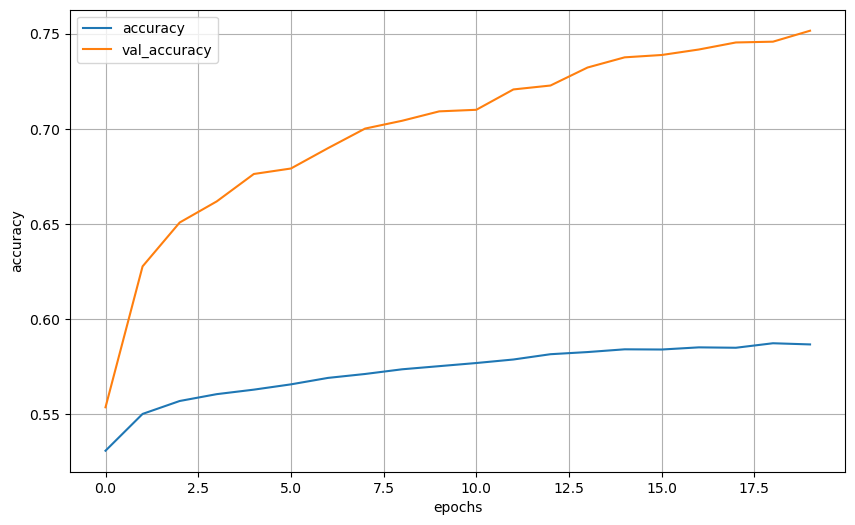

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [87]:
model.evaluate(X_test, y_test)

195/195 [==============================] - 0s 720us/step - loss: 0.8979 - accuracy: 0.6220


[0.8979254961013794, 0.6220333576202393]

In [88]:
model.predict(X_test).round(0)

195/195 [==============================] - 0s 641us/step


array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.]], dtype=float32)

Deshacemos la normalización para obtener los valores reales de MSE y MAE. Con ellos, será más fácil evaluar el resultado de nuestro modelo.

In [89]:
from sklearn.metrics import confusion_matrix, classification_report  

In [90]:
#Predict
y_prediction = model.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)

195/195 [==============================] - 0s 631us/step
[[0.77939646 0.79428571 0.50097943]
 [0.10275754 0.08285714 0.08080313]
 [0.11784599 0.12285714 0.41821743]]


In [91]:
snn_pred = model.predict(X_test, batch_size=32, verbose=1)  
snn_predicted = np.argmax(snn_pred, axis=1)


#Creamos la matriz de confusión
snn_cm = confusion_matrix(y_test, snn_predicted)

snn_cm

195/195 [==============================] - 0s 644us/step


array([[2996,  278, 1023],
       [ 395,   29,  165],
       [ 453,   43,  854]], dtype=int64)

In [92]:
snn_report = classification_report(y_test, snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      4297
           1       0.08      0.05      0.06       589
           2       0.42      0.63      0.50      1350

    accuracy                           0.62      6236
   macro avg       0.43      0.46      0.43      6236
weighted avg       0.64      0.62      0.62      6236

